# DNN-inference on Brain Tumor Dataset

By using Dnn inference method, we will study if there exist any connection between specific region of brain and brain tumor.

In [1]:
# Import relative package

import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils
import matplotlib.cm as cm    
from tensorflow import keras
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model
import dnn_inference
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

2024-02-21 19:04:16.214321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMG_PATH = []

IMG_PATH = 'brain_tumor_dataset/'
augmented_data_path = 'augmented_images/'

## Data Preprocessing

This portion of the code is responsible for image data processing. It first reads the image data, and then the code identifies the edge points of the area occupied by the brain in the image and removes excess black areas. This preprocessing step effectively enhances the model's accuracy.

In [5]:
def crop_brain_contour(image, plot=False):
    try:
        gray = cv2.GaussianBlur(image, (5, 5), 0)
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        if not cnts:
            raise ValueError("No contours found")
        c = max(cnts, key=cv2.contourArea)

        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

        if plot:
            plt.figure()
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title('Original Image')
            plt.subplot(1, 2, 2)
            plt.imshow(new_image)
            plt.title('Cropped Image')
            plt.show()

        return new_image
    except Exception as e:
        print(f"Error in cropping: {e}")
        return None  # Return None or a default image in case of an error


def load_data(dir_list, image_size):
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            try:
                image_path = os.path.join(directory, filename)
                image = cv2.imread(image_path, flags=0)  # Reading in grayscale
                if image is not None:
                    image = crop_brain_contour(image, plot=False)
                    #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
                    image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
                    image = image / 255.  # Normalize values
                    X.append(image)
                    y.append([1 if directory[-3:] == 'yes' else 0])
                else:
                    print(f"Warning: Unable to read {image_path}, skipping this file.")
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    X = np.array(X)
    y = np.array(y)
    X, y = shuffle(X, y)
    X = X.reshape(X.shape[0], image_width, image_height, 1)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y


In [6]:
Image_yes = IMG_PATH+'yes'
Image_no = IMG_PATH+'no'

IMG_WIDTH, IMG_HEIGHT = (112, 112)

X, y = load_data([Image_yes, Image_no], (IMG_WIDTH, IMG_HEIGHT))
y_cat = keras.utils.to_categorical(y, 2)

Number of examples is: 253
X shape is: (253, 112, 112, 1)
y shape is: (253, 1)


### Visualize Images

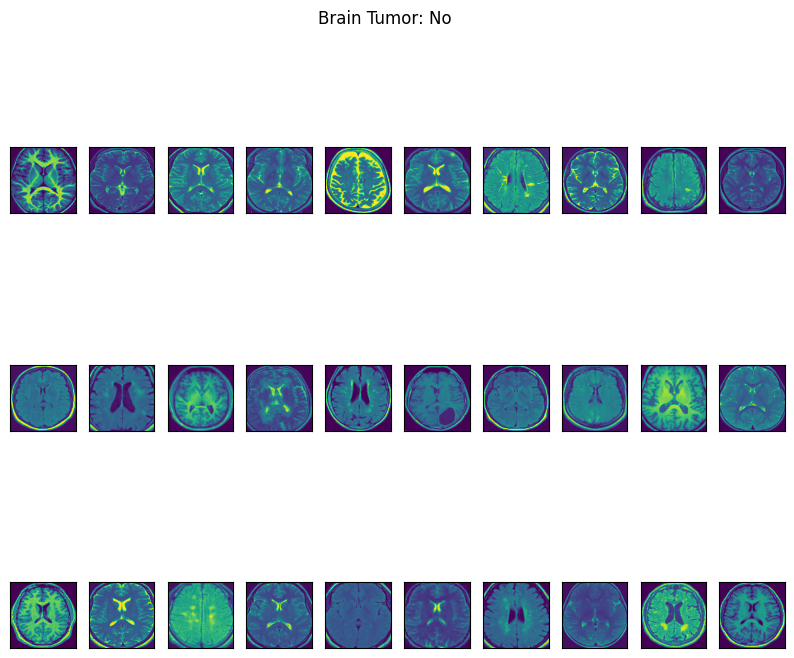

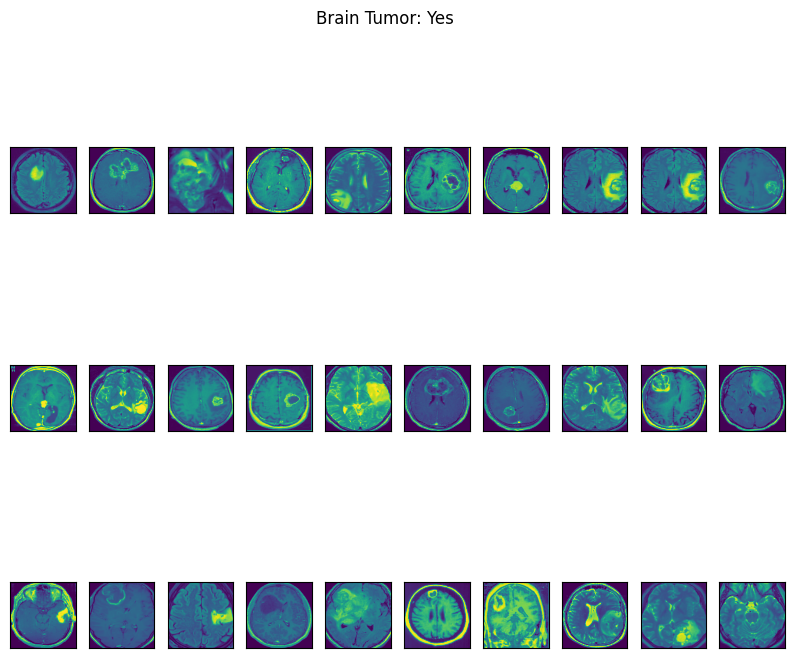

In [7]:
def plot_sample_images(X, y, n=30):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

plot_sample_images(X, y)

## DNN inference

Construct a convolution neural network to predict if there exist brain tumor from images.

In [8]:
def cnn_model():

    model = Sequential()

    model.add(Conv2D(32, kernel_size=(5, 5), input_shape=(112, 112, 1), padding = 'Same'))
    model.add(Conv2D(32, kernel_size=(5, 5),  activation ='relu', padding = 'Same'))


    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size = (5,5), activation ='relu', padding = 'Same'))
    model.add(Conv2D(64, kernel_size = (5,5), activation ='relu', padding = 'Same'))

    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss = "categorical_crossentropy", optimizer='Adamax')
    return model

model_null, model_alter = cnn_model(), cnn_model()

## Perform significance test 

### One-split test

In [16]:
## Inference based on dnn_inference
from dnn_inference.sig_test import split_test
## testing based on learning models

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min',verbose=0, patience=20, restore_best_weights=True)


fit_params = {'callbacks': [es],
            'epochs': 30,
            'batch_size': 32,
            'validation_split': .2,
            'verbose': 0}

## testing params
test_params = { 'split': "one-split",
                'inf_ratio': None,
                'perturb': None,
                'cv_num': 2,
                'cp': 'hommel',
                'verbose': 2}

## tuning params
tune_params = { 'num_perm': 100,
                'ratio_grid': [.2, .4, .6, .8],
                'if_reverse': 0,
                'pertube': None,
                'perturb_range': 2.**np.arange(-3,3,.1),
                'tune_ratio_method': 'fuse',
                'tune_pb_method': 'fuse',
                'cv_num': 2,
                'cp': 'hommel',
                'verbose': 2}


In [10]:
#from dnn_inference.sig_test import split_test
## testing based on learning models
inf_feats = [[np.arange(0,56),np.arange(0,112)],[np.arange(57,112),np.arange(0,112)]]
cue_1 = split_test(inf_feats=inf_feats, model_null = model_null, model_alter=model_alter, eva_metric='zero-one')
P_value_1 = cue_1.testing(X, y_cat, fit_params, test_params, tune_params)

INFO:tensorflow:Assets written to: ./saved/split_test/02-21_19-06/model_null_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/02-21_19-06/model_null_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/02-21_19-06/model_alter_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/02-21_19-06/model_alter_init/assets


==================== one-split test for 0-th Hypothesis ====================
(tuneHP: ratio) Est. Type 1 error: 0.020; inf sample ratio: 0.200
✅ (tuneHP: ratio) Done with inf sample ratio: 0.200
(tuneHP: pb) Est. Type 1 error: 0.020; perturbation level: 0.125
✅ (tuneHP: pb) Done with inf pb level: 0.125
cv: 0; p_value: 0.38527; loss_null: 0.32000(0.46648); loss_alter: 0.34000(0.47371)
cv: 1; p_value: 0.00646; loss_null: 0.28000(0.44900); loss_alter: 0.52000(0.49960)
 🧪 0-th Hypothesis: reject H0 with p_value: 0.019
==================== one-split test for 1-th Hypothesis ====================
(tuneHP: ratio) Est. Type 1 error: 0.030; inf sample ratio: 0.200
✅ (tuneHP: ratio) Done with inf sample ratio: 0.200
(tuneHP: pb) Est. Type 1 error: 0.000; perturbation level: 0.125
✅ (tuneHP: pb) Done with inf pb level: 0.125
cv: 0; p_value: 0.09189; loss_null: 0.32000(0.46648); loss_alter: 0.44000(0.49639)
cv: 1; p_value: 0.79222; loss_null: 0.40000(0.48990); loss_alter: 0.34000(0.47371)
 🧪 1-th 

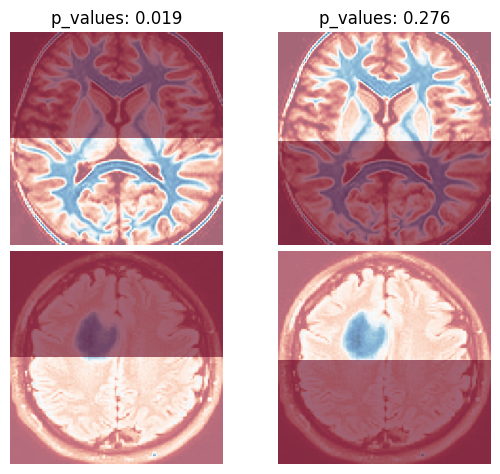

P-value: [0.019376862476507956, 0.27566179410122343]


In [11]:
cue_1.visual(X,y_cat)
print('P-value: %s'%P_value_1)

In [17]:
from dnn_inference.sig_test import split_test
## testing based on learning models
inf_feats = [[np.arange(0,112),np.arange(0,56)],[np.arange(0,112),np.arange(57,112)]]
cue_2 = split_test(inf_feats=inf_feats, model_null = model_null, model_alter=model_alter, eva_metric='zero-one')
P_value_2 = cue_2.testing(X, y_cat, fit_params, test_params, tune_params)

INFO:tensorflow:Assets written to: ./saved/split_test/02-26_15-30/model_null_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/02-26_15-30/model_null_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/02-26_15-30/model_alter_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/02-26_15-30/model_alter_init/assets


==================== one-split test for 0-th Hypothesis ====================
(tuneHP: ratio) Est. Type 1 error: 0.060; inf sample ratio: 0.200
(tuneHP: ratio) Est. Type 1 error: 0.310; inf sample ratio: 0.400
(tuneHP: ratio) Est. Type 1 error: 0.020; inf sample ratio: 0.600
✅ (tuneHP: ratio) Done with inf sample ratio: 0.600
(tuneHP: pb) Est. Type 1 error: 0.010; perturbation level: 0.125
✅ (tuneHP: pb) Done with inf pb level: 0.125
cv: 0; p_value: 0.31717; loss_null: 0.43046(0.49514); loss_alter: 0.45033(0.49753)
cv: 1; p_value: 0.44297; loss_null: 0.35099(0.47728); loss_alter: 0.35762(0.47930)
 🧪 0-th Hypothesis: accept H0 with p_value: 0.664
==================== one-split test for 1-th Hypothesis ====================
(tuneHP: ratio) Est. Type 1 error: 0.220; inf sample ratio: 0.200
(tuneHP: ratio) Est. Type 1 error: 0.010; inf sample ratio: 0.400
✅ (tuneHP: ratio) Done with inf sample ratio: 0.400
(tuneHP: pb) Est. Type 1 error: 0.000; perturbation level: 0.125
✅ (tuneHP: pb) Done w

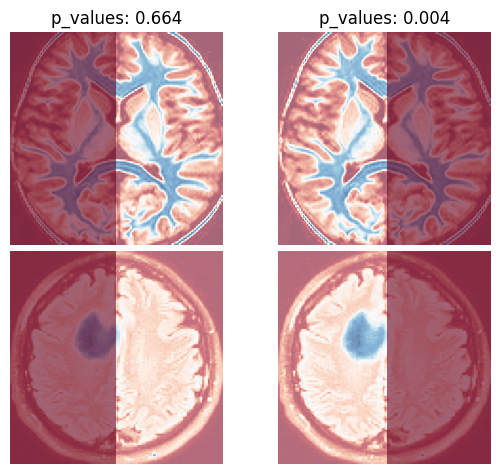

P-value: [0.6644538167376683, 0.004014340942036222]


In [18]:
cue_2.visual(X,y_cat)
print('P-value: %s'%P_value_2)

In [8]:
from dnn_inference.sig_test import split_test
## testing based on learning models
inf_feats = [[np.arange(28,84),np.arange(0,112)],[np.arange(0,112),np.arange(28,84)]]
cue_3 = split_test(inf_feats=inf_feats, model_null = model_null, model_alter=model_alter, eva_metric='zero-one')
P_value_3 = cue_3.testing(X, y_cat, fit_params, test_params, tune_params)

INFO:tensorflow:Assets written to: ./saved/split_test/10-25_10-55/model_null_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/10-25_10-55/model_null_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/10-25_10-55/model_alter_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/10-25_10-55/model_alter_init/assets


==================== one-split test for 0-th Hypothesis ====================
(tuneHP: ratio) Est. Type 1 error: 0.020; inf sample ratio: 0.200
✅ (tuneHP: ratio) Done with inf sample ratio: 0.200
(tuneHP: pb) Est. Type 1 error: 0.000; perturbation level: 0.125
✅ (tuneHP: pb) Done with inf pb level: 0.125
cv: 0; p_value: 0.24860; loss_null: 0.32000(0.46648); loss_alter: 0.36000(0.48000)
cv: 1; p_value: 0.19060; loss_null: 0.38000(0.48539); loss_alter: 0.48000(0.49960)
 🧪 0-th Hypothesis: accept H0 with p_value: 0.373
==================== one-split test for 1-th Hypothesis ====================
(tuneHP: ratio) Est. Type 1 error: 0.040; inf sample ratio: 0.200
✅ (tuneHP: ratio) Done with inf sample ratio: 0.200
(tuneHP: pb) Est. Type 1 error: 0.060; perturbation level: 0.125
(tuneHP: pb) Est. Type 1 error: 0.050; perturbation level: 0.134
(tuneHP: pb) Est. Type 1 error: 0.050; perturbation level: 0.144
(tuneHP: pb) Est. Type 1 error: 0.070; perturbation level: 0.154
(tuneHP: pb) Est. Type 1

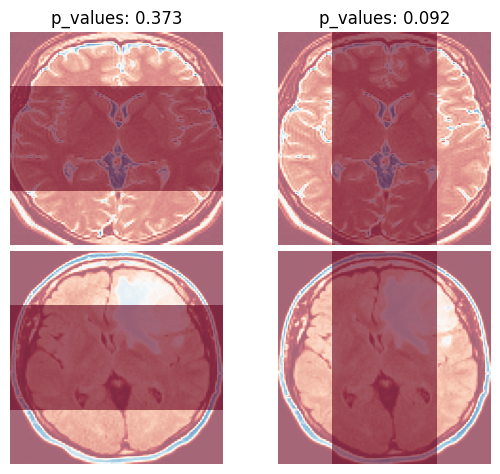

P-value: [0.3728981068436825, 0.09249793702881093]


In [18]:
cue_3.visual(X,y_cat)
print('P-value: %s'%P_value_3)

### Two-split test

In [14]:
es = EarlyStopping(monitor='val_loss', mode='min',verbose=0, patience=20, restore_best_weights=True)


fit_params = {'callbacks': [es],
            'epochs': 30,
            'batch_size': 32,
            'validation_split': .2,
            'verbose': 0}

## testing params
test_params = { 'split': "two-split",
                'inf_ratio': None,
                'perturb': 0,
                'cv_num': 1,
                'cp': 'hommel',
                'verbose': 1}

## tuning params
tune_params = { 'num_perm': 100,
                'ratio_grid': [.2, .4, .6, .8],
                'if_reverse': 0,
                'pertube': 0,
                'perturb_range': 2.**np.arange(-3,3,.1),
                'tune_ratio_method': 'fuse',
                'tune_pb_method': 'fuse',
                'cv_num': 1,
                'cp': 'hommel',
                'verbose': 1}


In [10]:
#from dnn_inference.sig_test import split_test
## testing based on learning models
inf_feats = [[np.arange(0,56),np.arange(0,112)],[np.arange(57,112),np.arange(0,112)]]
cue_1_twosplit = split_test(inf_feats=inf_feats, model_null = model_null, model_alter=model_alter, eva_metric='zero-one')
P_value_1_twosplit = cue_1_twosplit.testing(X, y_cat, fit_params, test_params, tune_params)

INFO:tensorflow:Assets written to: ./saved/split_test/12-11_17-28/model_null_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/12-11_17-28/model_null_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/12-11_17-28/model_alter_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/12-11_17-28/model_alter_init/assets


==================== two-split test for 0-th Hypothesis ====================
✅ (tuneHP: ratio) Done with inf sample ratio: 0.200
 🧪 0-th Hypothesis: accept H0 with p_value: 0.091
==================== two-split test for 1-th Hypothesis ====================
✅ (tuneHP: ratio) Done with inf sample ratio: 0.200
 🧪 1-th Hypothesis: accept H0 with p_value: 0.199


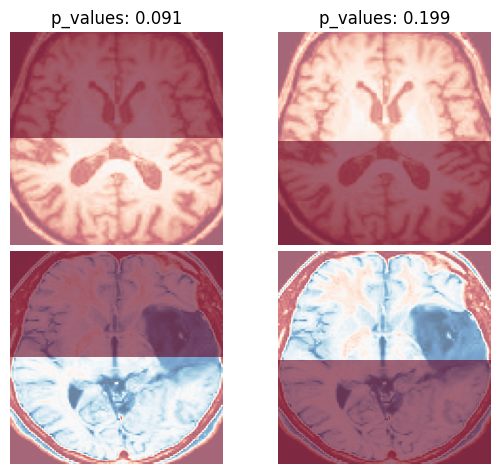

P-value: [0.09072460386071024, 0.19938613737915284]


In [11]:
cue_1_twosplit.visual(X,y_cat)
print('P-value: %s'%P_value_1_twosplit)

In [9]:
inf_feats = [[np.arange(0,112),np.arange(0,56)],[np.arange(0,112),np.arange(57,112)]]
cue_2_twosplit = split_test(inf_feats=inf_feats, model_null = model_null, model_alter=model_alter, eva_metric='zero-one')
P_value_2_twosplit = cue_2_twosplit.testing(X, y_cat, fit_params, test_params, tune_params)

INFO:tensorflow:Assets written to: ./saved/split_test/12-05_13-54/model_null_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/12-05_13-54/model_null_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/12-05_13-54/model_alter_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/12-05_13-54/model_alter_init/assets


==================== two-split test for 0-th Hypothesis ====================
✅ (tuneHP: ratio) Done with inf sample ratio: 0.600
 🧪 0-th Hypothesis: reject H0 with p_value: 0.009
==================== two-split test for 1-th Hypothesis ====================
✅ (tuneHP: ratio) Done with inf sample ratio: 0.200
 🧪 1-th Hypothesis: accept H0 with p_value: 0.179


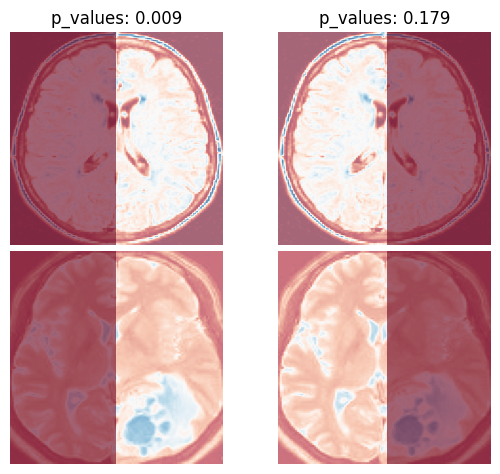

P-value: [0.009299616464203722, 0.17886242169417216]


In [10]:
cue_2_twosplit.visual(X,y_cat)
print('P-value: %s'%P_value_2_twosplit)

In [13]:
inf_feats = [[np.arange(28,84),np.arange(0,112)],[np.arange(0,112),np.arange(28,84)]]
cue_3_twosplit = split_test(inf_feats=inf_feats, model_null = model_null, model_alter=model_alter, eva_metric='zero-one')
P_value_3_twosplit = cue_3_twosplit.testing(X, y_cat, fit_params, test_params, tune_params)

INFO:tensorflow:Assets written to: ./saved/split_test/12-11_18-30/model_null_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/12-11_18-30/model_null_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/12-11_18-30/model_alter_init/assets


INFO:tensorflow:Assets written to: ./saved/split_test/12-11_18-30/model_alter_init/assets


==================== two-split test for 0-th Hypothesis ====================
✅ (tuneHP: ratio) Done with inf sample ratio: 0.200
 🧪 0-th Hypothesis: accept H0 with p_value: 0.352
==================== two-split test for 1-th Hypothesis ====================
✅ (tuneHP: ratio) Done with inf sample ratio: 0.200
 🧪 1-th Hypothesis: accept H0 with p_value: 0.308


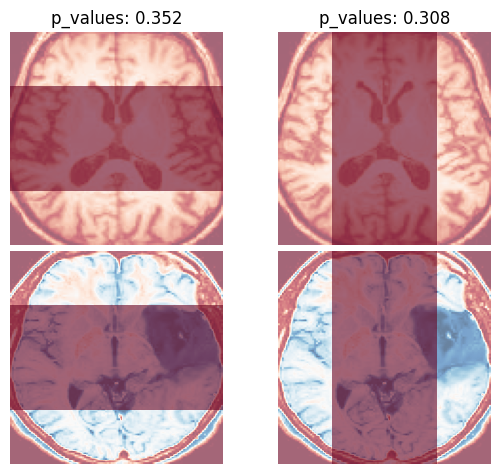

P-value: [0.3523257305570826, 0.30765127784525537]


In [14]:
cue_3_twosplit.visual(X,y_cat)
print('P-value: %s'%P_value_3_twosplit)

| Region | One-Split P-Value | Two-Split P-Value |
|------|-------------------|-------------------|
| upper    | 0.019             | 0.019             |
| lower    | 0.276             | 0.199             |
| left   | 0.664          |     0.009        |
| right | 0.004             | 0.179               |
|   horizontal band | 0.373             | 0.352               |
| vertical band | 0.092               | 0.308               |


